In [12]:
import numpy as np
import matplotlib.pyplot as plt
from grid import Grid
from perturb import random_field
from assim_tools.multiscale import fft2, ifft2, get_wn
import pyproj
from numba import njit
    

##scaled wavenumber k for pseudospectral method
def get_scaled_wn(x, dx):
    n = x.shape[0]
    wni, wnj = get_wn(x)
    ki = (2.*np.pi) * wni / (n*dx)
    kj = (2.*np.pi) * wnj / (n*dx)
    return ki, kj


##random realization of model initial condition
##amp: wind speed amplitude; power_law: wind field power spectrum slope

def gen_random_flow(grid, amp, power_law):
    fld = np.zeros((2,)+grid.x.shape)
    dx = grid.dx
    ##generate random streamfunction for the wind
    psi = random_field(grid, lambda k: k**((power_law-3)/2))
    ##convert to wind
    u = -(np.roll(psi, -1, axis=0) - np.roll(psi, 1, axis=0)) / (2.0*dx)
    v = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2.0*dx)
    ##normalize and scale to required amp
    u = amp * (u - np.mean(u)) / np.std(u)
    v = amp * (v - np.mean(v)) / np.std(v)
    fld[0, :] = u
    fld[1, :] = v
    return fld

##rankine vortex. Vmax: maximum wind speed, Rmw: radius of max wind, loc_sprd: the spread in center location
def gen_vortex(grid, Vmax, Rmw, loc_sprd=0):
    fld = np.zeros((2,)+grid.x.shape)
    ny, nx = grid.x.shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    center_x = 0.5*nx + np.random.normal(0, loc_sprd)
    center_y = 0.5*ny + np.random.normal(0, loc_sprd)
    dist = np.sqrt((x-center_x)**2 + (y-center_y)**2)
    dist[np.where(dist==0)] = 1e-10  ##avoid divide by 0
    wspd = np.zeros(dist.shape)
    ind = np.where(dist <= Rmw)
    wspd[ind] = Vmax * dist[ind] / Rmw
    ind = np.where(dist > Rmw)
    wspd[ind] = Vmax * (Rmw / dist[ind])**1.5
    wspd[np.where(dist==0)] = 0
    fld[0, :] = -wspd * (y - center_y) / dist  ##u component
    fld[1, :] = wspd * (x - center_x) / dist   ##v component
    return fld


##model forecast step:
def advance_time(X, dx, dt, smalldt, gen, diss):
    ##input wind components, convert to spectral space
    u = fft2(X[0, :, :])
    v = fft2(X[1, :, :])
    ##convert to zeta
    ki, kj = get_scaled_wn(u, dx)
    zeta = 1j * (ki*v - kj*u)
    k2 = ki**2 + kj**2
    k2[0, 0] = 1.
    #k2 = np.where(k2!=0, k2, np.ones_like(k2)) #avoid singularity in inversion
    ##run time loop:
    for n in range(int(dt/smalldt)):
        ##use rk4 numeric scheme to integrate forward in time:
        rhs1 = forcing(u, v, zeta, dx, gen, diss)
        zeta1 = zeta + 0.5*smalldt*rhs1
        rhs2 = forcing(u, v, zeta1, dx, gen, diss)
        zeta2 = zeta + 0.5*smalldt*rhs2
        rhs3 = forcing(u, v, zeta2, dx, gen, diss)
        zeta3 = zeta + smalldt*rhs3
        rhs4 = forcing(u, v, zeta3, dx, gen, diss)
        zeta = zeta + smalldt*(rhs1/6.0 + rhs2/3.0 + rhs3/3.0 + rhs4/6.0)
        ##inverse zeta to get u, v
        psi = -zeta / k2
        u = -1j * kj * psi
        v = 1j * ki * psi
    X1 = X.copy()
    X1[0, :, :] = ifft2(u)
    X1[1, :, :] = ifft2(v)
    return X1

def forcing(u, v, zeta, dx, gen, diss):
    ki, kj = get_scaled_wn(zeta, dx)
    ug = ifft2(u)
    vg = ifft2(v)
    ##advection term:
    f = -fft2(ug*ifft2(1j*ki*zeta) + vg*ifft2(1j*kj*zeta))
    ##generation term:
    vmax = np.max(np.sqrt(ug**2+vg**2))
    if vmax > 75:  ##cut off generation if vortex intensity exceeds limit
        gen = 0
    n = zeta.shape[0]
    k2d = np.sqrt(ki**2 + kj**2)*(n*dx)/(2.*np.pi)
    kc = 8
    dk = 3
    gen_response = np.exp(-0.5*(k2d-kc)**2/dk**2)
    f += gen*gen_response*zeta
    ##dissipation term:
    f -= diss*(ki**2+kj**2)*zeta
    return f

In [13]:
nx = 128    # number of grid points i, j directions
ny = 128 
nv = 2     # number of variables, (u, v)
dx = 9000
dt = 3600
nt = 36

x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x *= dx
y *= dx
proj = pyproj.Proj('+proj=stere')
grid = Grid(proj, x, y, cyclic_dim='xy')

smalldt = 60
gen = 5e-5
diss = 3e3 

### vortex parameters
Vbg = 5      ##background flow amplitude
Vmax = 35     ## maximum wind speed (vortex intensity)
Rmw = 5       ## radius of maximum wind (vortex size)

fld = np.zeros((nt+1, 2,)+grid.x.shape)
bkg_flow = gen_random_flow(grid, Vbg, -3)
vortex = gen_vortex(grid, Vmax, Rmw)
fld[0, :, :, :] = bkg_flow + vortex

In [14]:
for t in range(nt):
    fld[t+1, :] = advance_time(fld[t, :], dx, dt, smalldt, gen, diss)


In [31]:
def draw_frame(t):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    c = grid.plot_field(ax, fld[t, 0,:], vmin=-50, vmax=50, cmap='bwr')
    grid.plot_vectors(ax, fld[t, :])
    ax.set_xlim(grid.x.min(), grid.x.max())
    ax.set_ylim(grid.y.min(), grid.y.max())
    #plt.savefig('{:03d}.png'.format(t))
    #plt.close() 
    

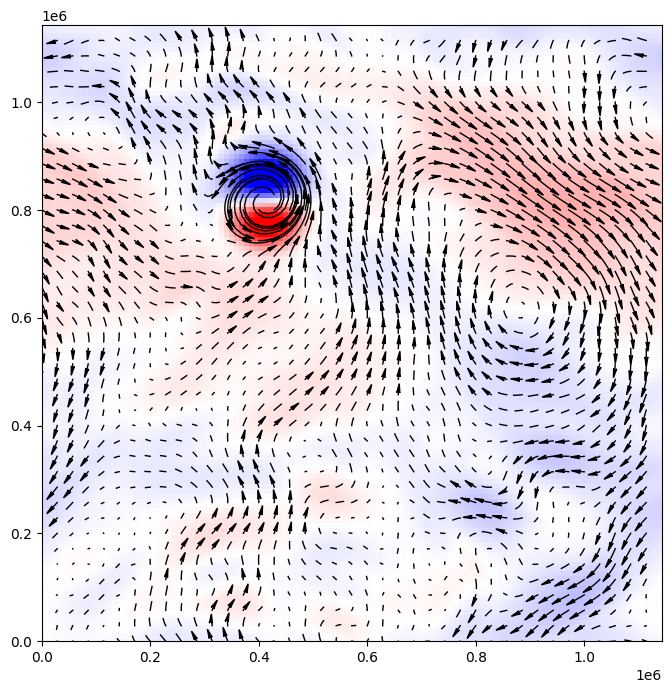

In [32]:
draw_frame(10)